In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Example vocabulary from count vectorizer
vectorizer = CountVectorizer()
corpus = [
    'Invincible is the best show ever'
]
vectorizer.fit(corpus)
print(vectorizer.vocabulary_)

{'invincible': 2, 'is': 3, 'the': 5, 'best': 0, 'show': 4, 'ever': 1}


N-gram Example:

In [6]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
vectorizer.fit(corpus)
print(vectorizer.vocabulary_)

{'invincible': 4, 'is': 7, 'the': 12, 'best': 0, 'show': 10, 'ever': 3, 'invincible is': 5, 'is the': 8, 'the best': 13, 'best show': 1, 'show ever': 11, 'invincible is the': 6, 'is the best': 9, 'the best show': 14, 'best show ever': 2}


We need to remove stop words and punctuation from the text before applying n-grams method for more accurate representation of the meaning.

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)

    # Remove stop words and lemmatize
    text_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(text_tokens)

In [12]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

corpus = [preprocess(text) for text in corpus]
print(corpus)

['thor eat pizza', 'Loki tall', 'Loki eat pizza']


In [13]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectorizer.fit(corpus)
print(vectorizer.vocabulary_)

{'thor': 7, 'eat': 0, 'pizza': 5, 'thor eat': 8, 'eat pizza': 1, 'loki': 2, 'tall': 6, 'loki tall': 4, 'loki eat': 3}


In [14]:
X = vectorizer.transform(corpus)
print(X.toarray())

[[1 1 0 0 0 1 0 1 1]
 [0 0 1 0 1 0 1 0 0]
 [1 1 1 1 0 1 0 0 0]]


Now we have the vector representation of the texts. We can use this vector representation for classification or clustering of the text.

# News Categorizing using n-gram method:

In [16]:
import pandas as pd
news = pd.read_json('news_dataset.json')
news.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [18]:
news.shape

(12695, 2)

In [17]:
print(news['category'].value_counts())

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64


In [19]:
news.isna().sum()

text        0
category    0
dtype: int64

To balance the categories, we will use undersampling method. We will take 1381 samples from each category.

In [22]:
def balance_data(data, random_state=42):
    categories = data['category'].unique()
    min_count = data['category'].value_counts().min()

    balanced_data = pd.DataFrame()
    for category in categories:
        category_data = data[data['category'] == category]
        balanced_data = pd.concat([balanced_data, category_data.sample(min_count, random_state=random_state)])

    return balanced_data

balanced_data = balance_data(news)
balanced_data.shape

(5524, 2)

In [24]:
print(balanced_data['category'].value_counts())

SCIENCE     1381
BUSINESS    1381
CRIME       1381
SPORTS      1381
Name: category, dtype: int64


In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(balanced_data['category'])
balanced_data['category'] = encoder.transform(balanced_data['category'])
balanced_data.category.value_counts()

2    1381
0    1381
1    1381
3    1381
Name: category, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_data['text'], 
                                                    balanced_data['category'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=balanced_data['category'])

print(X_train.shape, X_test.shape)

(4419,) (1105,)


In [28]:
y_train.value_counts()

0    1105
3    1105
1    1105
2    1104
Name: category, dtype: int64

In [29]:
y_test.value_counts()

2    277
0    276
1    276
3    276
Name: category, dtype: int64

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       276
           1       0.88      0.92      0.90       276
           2       0.90      0.81      0.85       277
           3       0.93      0.84      0.88       276

    accuracy                           0.87      1105
   macro avg       0.87      0.87      0.87      1105
weighted avg       0.87      0.87      0.87      1105



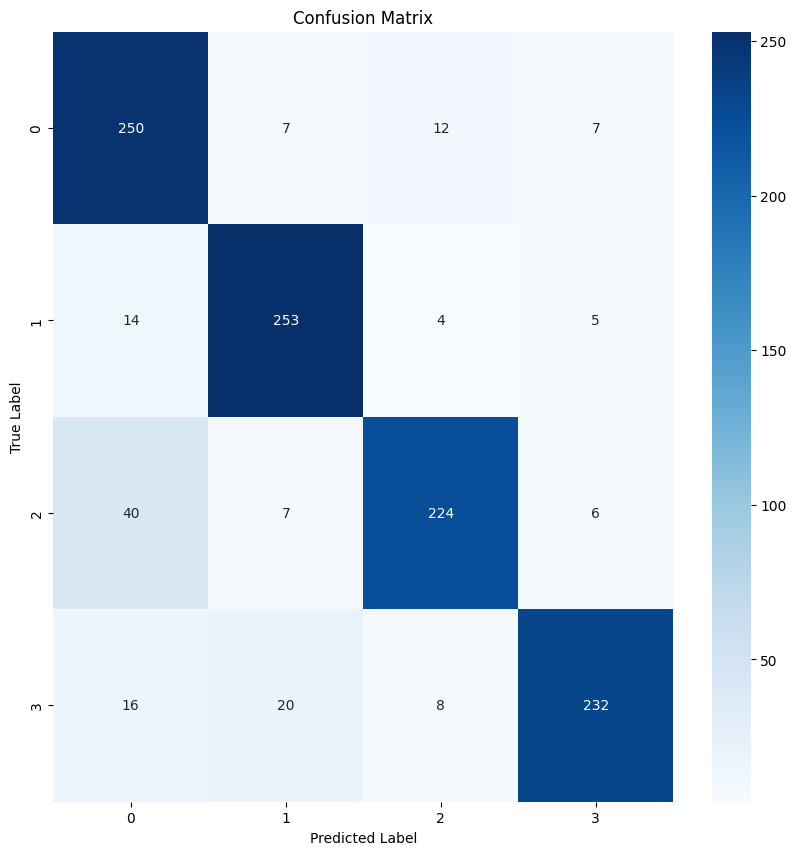

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer()),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       276
           1       0.89      0.90      0.90       276
           2       0.91      0.76      0.83       277
           3       0.94      0.82      0.87       276

    accuracy                           0.85      1105
   macro avg       0.87      0.85      0.85      1105
weighted avg       0.87      0.85      0.85      1105



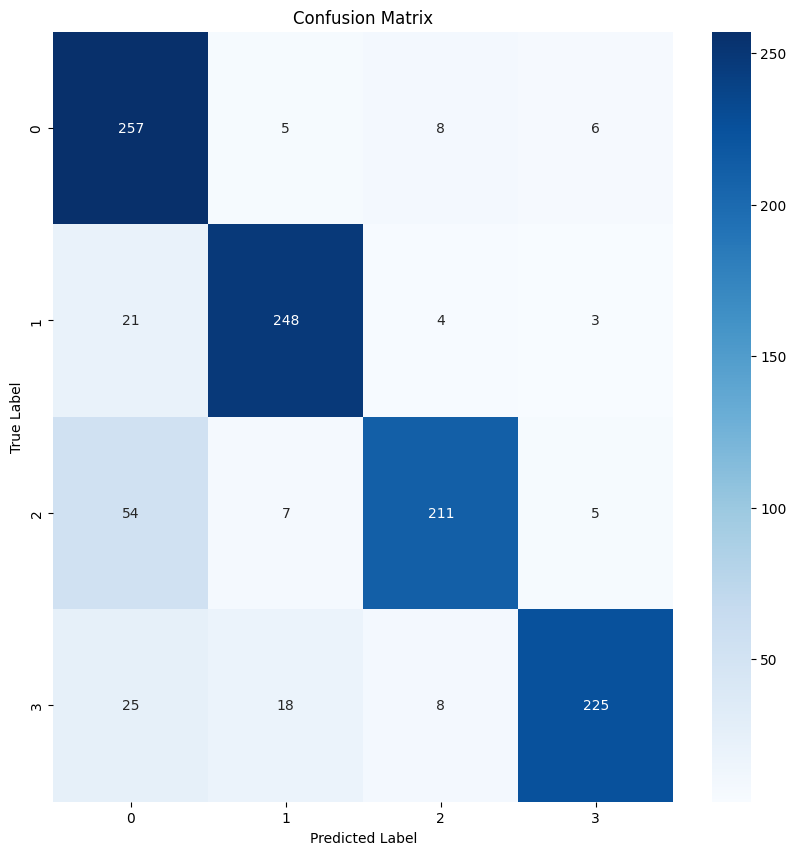

In [31]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 2))),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [32]:
balanced_data['text'] = balanced_data['text'].apply(preprocess)
balanced_data.head()

,text,category
2787,Cute Bats reveal Common Dogs Cats see puppy,2
6812,Science Wasabi pave way New Pain Meds,2
2415,Scientist March hard believe 92 year Scopes Mo...,2
7507,clumping Study Pokes Holes Black Hole Theory,2
7138,Hubble Space Telescope Shatters Cosmic Distanc...,2


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_data['text'], 
                                                    balanced_data['category'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=balanced_data['category'])

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer()),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       276
           1       0.88      0.95      0.91       276
           2       0.90      0.82      0.86       277
           3       0.91      0.85      0.88       276

    accuracy                           0.88      1105
   macro avg       0.88      0.88      0.88      1105
weighted avg       0.88      0.88      0.88      1105



In [34]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 2))),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       276
           1       0.87      0.93      0.90       276
           2       0.91      0.81      0.86       277
           3       0.92      0.85      0.88       276

    accuracy                           0.87      1105
   macro avg       0.88      0.87      0.87      1105
weighted avg       0.88      0.87      0.87      1105



## Exercise : Fake News Detection

About Data: Fake News Detection
Credits: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

This data consists of two columns. - Text - label

Text is the statements or messages regarding a particular event/situation.

label feature tells whether the given Text is Fake or Real.

As there are only 2 classes, this problem comes under the Binary Classification.

In [35]:
df = pd.read_csv("Fake_Real_Data.csv")
print(df.shape)
df.head()

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [36]:
df.label.value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

Labels look balanced.

In [39]:
df["label_num"] = df.label.map({'Fake': 1, 'Real': 0})
df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,1
1,U.S. conservative leader optimistic of common ...,Real,0
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,0
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,1
4,Democrats say Trump agrees to work on immigrat...,Real,0


# Modelling without Text Preprocessing:

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'],
                                                    df['label_num'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['label_num'])
print(X_train.shape, X_test.shape)

(7920,) (1980,)


Attempt 1 :

using sklearn pipeline module create a classification pipeline to classify the Data.
* Note:

using CountVectorizer with unigram, bigram, and trigrams.
use KNN as the classifier with n_neighbors of 10 and metric as 'euclidean' distance.
print the classification report.

In [44]:
# import KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 1))),
    ('KNN Classifier', KNeighborsClassifier(n_neighbors=10,metric='euclidean'))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.98      0.90      0.93      1000

    accuracy                           0.94      1980
   macro avg       0.94      0.94      0.94      1980
weighted avg       0.94      0.94      0.94      1980



Attempt 2 :

using the sklearn pipeline module create a classification pipeline to classify the Data.
* Note:

using CountVectorizer with unigram, bigram, and trigrams.
use KNN as the classifier with n_neighbors of 10 and metric as 'cosine' distance.
print the classification report.

In [48]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 1))),
    ('KNN Classifier', KNeighborsClassifier(n_neighbors=10,metric='cosine'))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       980
           1       1.00      0.78      0.88      1000

    accuracy                           0.89      1980
   macro avg       0.91      0.89      0.89      1980
weighted avg       0.91      0.89      0.89      1980



Attempt 3 :

using the sklearn pipeline module create a classification pipeline to classify the Data.
Note:

using CountVectorizer with only trigrams.
use RandomForest as the classifier.
print the classification report.

In [50]:
# import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(3, 3))),
    ('Forest Classifier', RandomForestClassifier(n_estimators=100))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



Attempt 4 :

using the sklearn pipeline module create a classification pipeline to classify the Data.
Note:

using CountVectorizer with both unigram and bigrams.
use Multinomial Naive Bayes as the classifier with an alpha value of 0.75.
print the classification report.

In [51]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 2))),
    ('MN Bayes Classifier', MultinomialNB(alpha=0.75))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.98      0.99      1000

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



Use text pre-processing to remove stop words, punctuations and apply lemmatization

In [52]:
df.Text = df.Text.apply(preprocess)
df.head()

,Text,label,label_num
0,Trump Surrogate BRUTALLY Stabs Pathetic vide...,Fake,1
1,U.S. conservative leader optimistic common gro...,Real,0
2,trump propose U.S. tax overhaul stir concern d...,Real,0
3,Court Forces Ohio allow million illegally pu...,Fake,1
4,Democrats Trump agree work immigration bill wa...,Real,0


In [53]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'],
                                                    df['label_num'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['label_num'])

Let's check the scores with our best model till now

Random Forest
Attempt1 :

using the sklearn pipeline module create a classification pipeline to classify the Data.
Note:

using CountVectorizer with only trigrams.
use RandomForest as the classifier.
print the classification report.

In [54]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(3, 3))),
    ('Forest Classifier', RandomForestClassifier(n_estimators=100))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       980
           1       0.92      0.98      0.95      1000

    accuracy                           0.95      1980
   macro avg       0.95      0.95      0.95      1980
weighted avg       0.95      0.95      0.95      1980



Attempt2 :

using the sklearn pipeline module create a classification pipeline to classify the Data.
Note:

using CountVectorizer with unigram, Bigram, and trigrams.
use RandomForest as the classifier.
print the classification report.

In [55]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 3))),
    ('Forest Classifier', RandomForestClassifier(n_estimators=100))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980

